<a href="https://colab.research.google.com/github/yukisuzuki121210240311-lgtm/SougouEnshu-A/blob/master/ensyu_3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DUETを用いた２マイク３音源の音源分離

音源数を増やして、３音源に対する音源分離を実装しましょう．

---

必要なモジュールをインストール & インポートします．

In [1]:
!pip install japanize-matplotlib -U
!pip install pesq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 42.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=84c52475db6f89a10f63c8cd6ac1b32bf2a194232eb781228d16b0105fb40312
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib
  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp312-cp312-linux_x86_64.whl size=284121 sha256=1627930b2de6cae9a2a09f8a046eb19b594568ddbadedd154b873697a3852c13
  Stored in directory: /root/.cache/pip/wheels/9b/d4/a4/9cf3512534cd47ce4a036d1593ee4013f2bf7509e631a147a3
Successfully built pesq


In [2]:
import numpy as np
import scipy.signal as sg          #  信号処理モジュール
import soundfile as sf              # wavファイルを扱う際のモジュール
from IPython.display import *  # iPython上でファイルを扱うためのモジュール
import urllib.request                # ファイルを読み込むためのモジュール
import matplotlib.pyplot as plt # 図を表示させるためのモジュール
import japanize_matplotlib      # 日本語を扱うためのモジュール
from pesq import pesq        # 音声評価用関数
from statistics import mode     # 最頻値計算用関数

## 0. 音声の読み込みと確認
音声ファイルの読み込みを行います．

```
音声ファイル群：
・ original_1.wav - 音源Aのモノラル音声
・ original_2.wav - 音源Bのモノラル音声
・ original_3.wav - 音源Cのモノラル音声
・ sound_SpeakerA.wav - 音源Aのみを収録したステレオ音声
・ sound_SpeakerB.wav - 音源Bのみを収録したステレオ音声
・ sound_SpeakerC.wav - 音源Cのみを収録したステレオ音声
・ sound_3souces_duet.wav - 音源Aと音源Bを同時に収録したステレオ音声
```

収録されたステレオ音声`sound_3souces_duet.wav`に音源分離を行います．
左右のチャンネルの音声をそれぞれ x_l，x_r とします．

また，DUETでは事前に各音源ごとに振幅比を計算する必要があります．
振幅比を

また，音声信号の各サンプルに対応する時刻[s]をもった配列として t を作成します．

In [3]:
# wavファイルをGoogle colabのワークスペースにもってくる
base_url = 'https://raw.githubusercontent.com/YosukeSugiura/SougouEnshu-A/master/' # Githubでrawデータを扱うためのurl
urllib.request.urlretrieve(base_url+'sound_3souces_duet.wav', 'sound_3souces_duet.wav') # マイクで収録したステレオ音声
urllib.request.urlretrieve(base_url+'sound_SpeakerA.wav', 'sound_SpeakerA.wav') # 音源Aのみ収録したステレオ音声
urllib.request.urlretrieve(base_url+'sound_SpeakerB.wav', 'sound_SpeakerB.wav') # 音源Bのみ収録したステレオ音声
urllib.request.urlretrieve(base_url+'sound_SpeakerC.wav', 'sound_SpeakerC.wav') # 音源Cのみ収録したステレオ音声
urllib.request.urlretrieve(base_url+'original_1.wav', 'original_1.wav') # 音源A
urllib.request.urlretrieve(base_url+'original_2.wav', 'original_2.wav') # 音源B
urllib.request.urlretrieve(base_url+'original_3.wav', 'original_3.wav') # 音源C

# wavファイルの読み込み (sf.readの戻り値：データ，サンプリング周波数)
wav_data, fs = sf.read('sound_3souces_duet.wav')  # マイクで収録したステレオ音声 (原音声1+原音声２)

# 事前に振幅比を計算するwavファイル
soundA, _ = sf.read('sound_SpeakerA.wav')  # 音源１のみ事前に収録したステレオ音声
soundB, _ = sf.read('sound_SpeakerB.wav')  # 音源２のみ事前に収録したステレオ音声
soundC, _ = sf.read('sound_SpeakerC.wav')  # 音源２のみ事前に収録したステレオ音声

originalA, _ = sf.read('original_1.wav')  # 音源１
originalB, _ = sf.read('original_2.wav')  # 音源２
originalC, _ = sf.read('original_3.wav')  # 音源３

# 各音声をチャンネルごとに分ける
# - 処理対象の音声
x_l = wav_data[:,0]
x_r = wav_data[:,1]
# - 音源1のみ事前に収録した音声
soundA_l = soundA[:,0]
soundA_r = soundA[:,1]
# - 音源2のみ事前に収録した音声
soundB_l = soundB[:,0]
soundB_r = soundB[:,1]
# - 音源3のみ事前に収録した音声
soundC_l = soundC[:,0]
soundC_r = soundC[:,1]

# 各サンプルの時刻(波形の図示で使う)
t   = np.arange(len(x_l))/fs
t1 = np.arange(len(originalA))/fs
t2 = np.arange(len(originalB))/fs
t3 = np.arange(len(originalC))/fs

振幅比を計算する音声を聞くこともできます(イヤホン推奨)．

In [4]:
print('音源Aのみの音声(事前推定用)')
display(Audio(soundA.T, rate=fs))
print('音源Bのみの音声(事前推定用)')
display(Audio(soundB.T, rate=fs))
print('音源Cのみの音声(事前推定用)')
display(Audio(soundC.T, rate=fs))

音源Aのみの音声(事前推定用)


音源Bのみの音声(事前推定用)


音源Cのみの音声(事前推定用)


## 1. 各音源の振幅比の事前推定

各音源が混合されず単体で収録された音声を用いて，事前に振幅比を計算します．
DUETでは，この振幅比に基づき音源を分離します．

まずはSTFTのパラメータを設定します．

In [5]:
# セグメント長，シフト長の指定
n_seg = 1024
n_overlap = round(1024*(1/2))

音源A，音源B，音源Cのみの音声をそれぞれSTFTします．

In [6]:
# 音源Aのスペクトログラム
_, _, Xa_l = sg.stft(soundA_l, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 左チャンネル
_, _, Xa_r = sg.stft(soundA_r, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 右チャンネル
# 音源Bのスペクトログラム
_, _, Xb_l = sg.stft(soundB_l, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 左チャンネル
_, _, Xb_r = sg.stft(soundB_r, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 右チャンネル
# 音源Cのスペクトログラム
_, _, Xc_l = sg.stft(soundC_l, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 左チャンネル
_, _, Xc_r = sg.stft(soundC_r, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 右チャンネル

信号のSTFT結果から振幅比を計算します．
音源Aにおける左チャンネルのスペクトログラムを`X_al`，右チャンネルのスペクトログラムを`X_ar`とします．
このとき，振幅比は

```
R_a = |X_al|/|X_ar|
```

で計算されます．音源B，音源Cにおいても振幅比を同様に計算し，それぞれ`R_b`，`R_c`とします．

In [7]:
#↓↓ 自身で書き換えて，音源A・Bそれぞれの振幅比R_a, R_b, R_cを計算する．
#--------------------------------------
eps = 1e-8
R_a = np.abs(Xa_l) / (np.abs(Xa_r) + eps)
R_b = np.abs(Xb_l) / (np.abs(Xb_r) + eps)
R_c = np.abs(Xc_l) / (np.abs(Xc_r) + eps)
#--------------------------------------
#↑↑ここまで

振幅比のヒストグラムを計算し，最頻値を計算します．

In [8]:
# 音源Aにおける振幅比 R_a のヒストグラムと最頻値
hist_ra, edge_ra = np.histogram(R_a.flatten(), bins=200, range=(0,4))
Ra_mod = edge_ra[hist_ra.argmax()] # ヒストグラム hist_ra の最頻値

# 音源Bにおける振幅比 R_b のヒストグラムと最頻値
hist_rb, edge_rb = np.histogram(R_b.flatten(), bins=200, range=(0,4))
Rb_mod = edge_rb[hist_rb.argmax()] # ヒストグラム hist_rb の最頻値

# 音源Cにおける振幅比 R_c のヒストグラムと最頻値
hist_rc, edge_rc = np.histogram(R_c.flatten(), bins=200, range=(0,4))
Rc_mod = edge_rc[hist_rc.argmax()] # ヒストグラム hist_rc の最頻値

得られた最頻値を出力します．

In [9]:
print("振幅比の最頻値：\n")
print("  音源A = {0:.4},\n  音源B = {1:.4},\n  音源C = {2:.4}".format(Ra_mod, Rb_mod, Rc_mod))

振幅比の最頻値：

  音源A = 1.98,
  音源B = 1.16,
  音源C = 0.68


確認のため，振幅比のヒストグラムを表示します．

Text(0.5, -0.4, '音源Cの振幅比のヒストグラム')

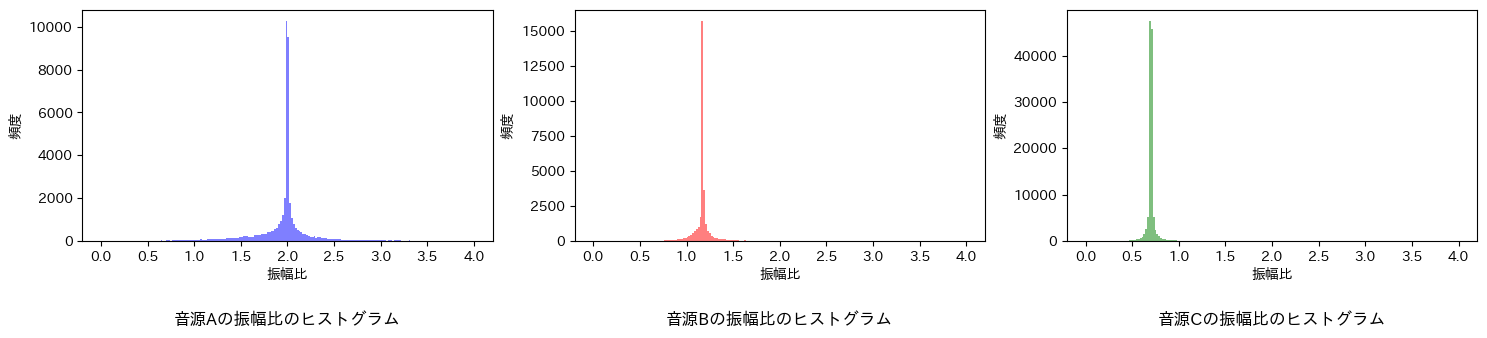

In [10]:
fig3, ax3 = plt.subplots(1, 3, num=1, figsize=(18,3))
_, _, _ = ax3[0].hist(R_a.flatten(), bins=200, alpha=0.5, histtype='stepfilled', range=(0,4), color='b')
_, _, _ = ax3[1].hist(R_b.flatten(), bins=200, alpha=0.5, histtype='stepfilled', range=(0,4), color='r')
_, _, _ = ax3[2].hist(R_c.flatten(), bins=200, alpha=0.5, histtype='stepfilled', range=(0,4), color='g')
for ax_ in ax3:
  ax_.set_xlabel("振幅比")
  ax_.set_ylabel("頻度")
ax3[0].set_title("音源Aの振幅比のヒストグラム", y=-0.4)
ax3[1].set_title("音源Bの振幅比のヒストグラム", y=-0.4)
ax3[2].set_title("音源Cの振幅比のヒストグラム", y=-0.4)

## 2. DUETによる音源分離

バイナリマスキングと同様，振幅比に基づき周波数マスクを作成して，音源分離を行いましょう．

まずは音声をフレームごとに分割して，短時間フーリエ変換(STFT)を行います．


In [11]:
# 各チャンネルごとに短時間フーリエ変換
f, t, X_l = sg.stft(x_l, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 左チャンネル
_, _, X_r = sg.stft(x_r, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 右チャンネル

マスクを作成し，フィルタリングを行いましょう．まずは音声の振幅比 R を計算し，以下のようにマスクを計算します．

今，Ra_mod < T1 < Rb_mod < T2 < Rc_mod と仮定すると，

> マスクの設定：
>
>  振幅比 R = |X_l| / |X_r| として
> - 音源Aのマスク G_a： R < T1 を満たすとき 1 ,その他で0
> - 音源Bのマスク G_b： T1 < R <  T2 を満たすとき 1, その他で0
> - 音源Cのマスク G_c： T2< R を満たすとき 1, その他で0

もちろん，Ra_mod，Rb_mod，Rc_mod の大小関係によってマスクの作り方は変える必要があります．

In [12]:
# マスクの作成

#↓↓ ここに音源分離を実現するマスクを作成しよう！
#     このサンプルコードでは，マスクのすべての値を1(=すべての周波数成分をそのまま通過させる)にしています．
#     自身で書き換えて，音源分離を実装しましょう．
#--------------------------------------

eps = 1e-8
R = np.abs(X_l) / (np.abs(X_r) + eps)

mods = np.array([Ra_mod, Rb_mod, Rc_mod])
order = np.argsort(mods)
sorted_mods = mods[order]

T1 = (sorted_mods[0] + sorted_mods[1]) / 2
T2 = (sorted_mods[1] + sorted_mods[2]) / 2

# - 各音源のマスクの配列を確保
G_a = np.zeros_like(R)   # X_lと同じサイズのマスクを作成
G_b = np.zeros_like(R)   # X_lと同じサイズのマスクを作成
G_c = np.zeros_like(R)   # X_lと同じサイズのマスクを作成

# - マスクの値を決める
mask_A = (R < T1)
mask_B = ((R >= T1) & (R < T2))
mask_C = (R >= T2)

G_list = [G_a, G_b, G_c]

G_list[order[0]][mask_A] = 1
G_list[order[1]][mask_B] = 1
G_list[order[2]][mask_C] = 1
#--------------------------------------
#↑↑ここまで

# スペクトログラムをマスキング
Y_a = G_a * X_l
Y_b = G_b * X_r
Y_c = G_c * X_r

各チャンネルの音声のスペクトログラムを図で確認します．ここでは音声の特徴が見やすいように，0Hz～2kHzまでを表示しています．

(このサンプルコードは，入力音声をそのまま出力するフィルタリングを行っています．したがってオリジナルのままでは，入力音声と同じスペクトログラムが得られます．)

Text(0.5, -0.1, '分離音声のスペクトログラム(左：音源A，中央：音源B，右：音源C)')

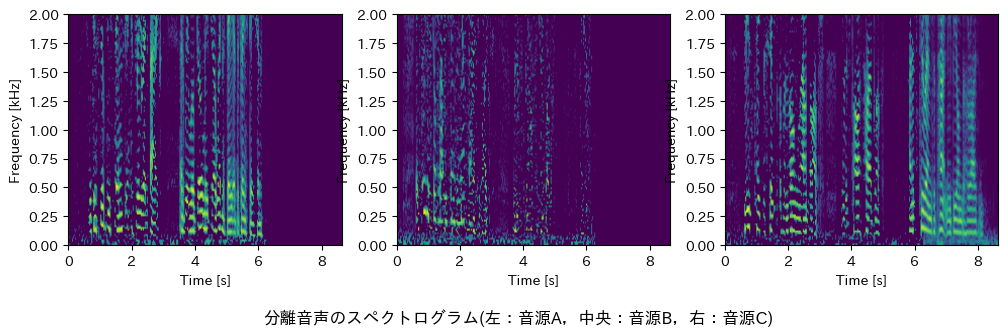

In [13]:
# パワースペクトログラムの計算
# 処理後の音声
S_a = 10*np.log10(np.abs(Y_a)**2+10**(-8))  # dB単位
S_b = 10*np.log10(np.abs(Y_b)**2+10**(-8)) # dB単位
S_c = 10*np.log10(np.abs(Y_c)**2+10**(-8)) # dB単位

# 1 x 2 のグラフを作成
fig3, ax3 = plt.subplots(1, 3, num=1, figsize=(12,3))

# 各グラフをプロット
extent = [t.min(), t.max(), f.min()/1000, f.max()/1000] # 時間の範囲
ax3[0].imshow(S_a, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)
ax3[1].imshow(S_b, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)
ax3[2].imshow(S_c, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)

# 軸名・範囲・タイトルの設定
for ax_ in ax3:
  ax_.set_ylim([0,2]) # 各グラフ，0~2kHzまでを表示
  ax_.set_ylabel("Frequency [kHz]")
  ax_.set_xlabel("Time [s]")
fig3.suptitle("分離音声のスペクトログラム(左：音源A，中央：音源B，右：音源C)", y=-0.1)

処理音声に対して逆短時間フーリエ変換(Inverse Short Fourier Transform:ISTFT)を行い，音声波形を復元します．関数`sg.istft`を用いれば，オーバーラップアドも同時に行ってくれます．



In [14]:
# 各チャンネルごとに短時間フーリエ変換
t, y_a = sg.istft(Y_a, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 戻り値：時刻，周波数スペクトル
_, y_b = sg.istft(Y_b, fs=fs, nperseg=n_seg, noverlap=n_overlap)
_, y_c = sg.istft(Y_c, fs=fs, nperseg=n_seg, noverlap=n_overlap)

音声波形を確認します．

Text(0.5, -0.1, '原音声の波形(左：音源A，中央：音源B，右：音源C)')

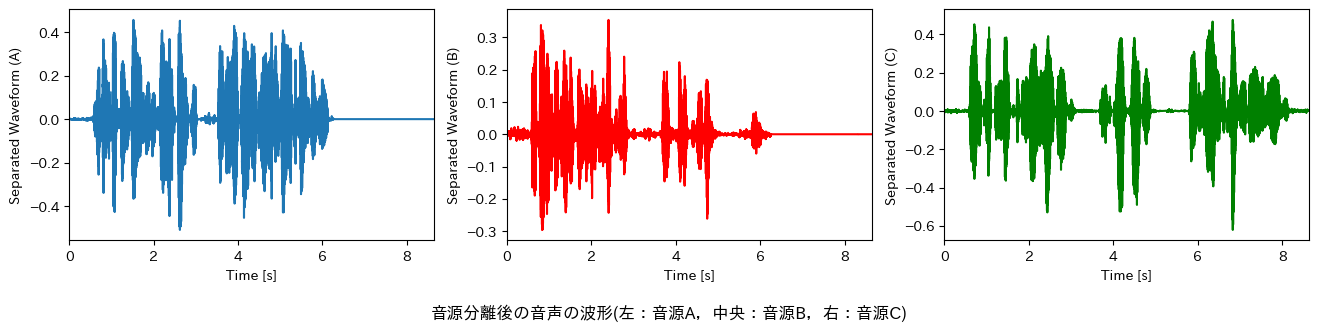

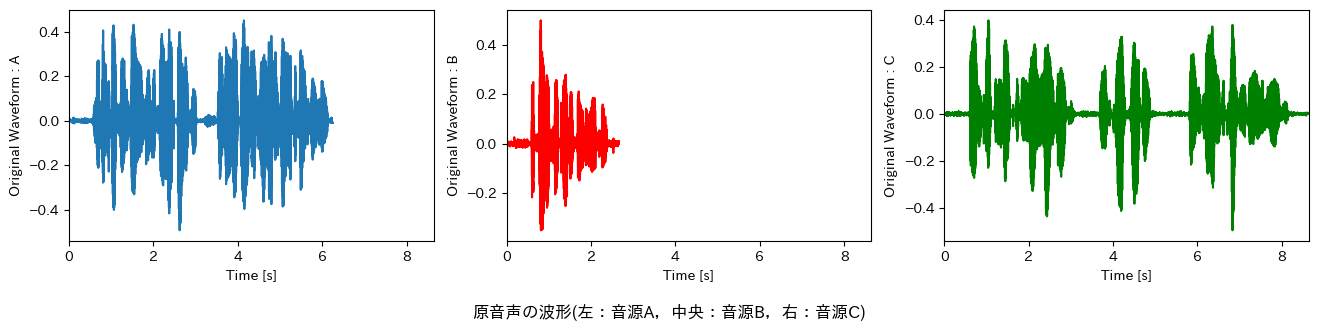

In [15]:
# 1 x 3 のグラフを２つ作成
fig4, ax4 = plt.subplots(1, 3, num=1, figsize=(16,3))
fig5, ax5 = plt.subplots(1, 3, num=2, figsize=(16,3))

# 各グラフをプロット
ax4[0].plot(t, y_a)                     # 原音声１
ax4[1].plot(t, y_b, color='r')          # 原音声２
ax4[2].plot(t, y_c, color='g')          # 原音声２
ax5[0].plot(t1, originalA)              # 処理後の左チャンネル
ax5[1].plot(t2, originalB,color='r')    # 処理後の左チャンネル
ax5[2].plot(t3, originalC,color='g')    # 処理後の左チャンネル

# x軸の範囲・ラベルの設定
for ax_ in np.r_[ax4,ax5]:
  ax_.set_xlim([t[0], t[-1]])
  ax_.set_xlabel("Time [s]")

# 軸のラベル・タイトルの設定
ax4[0].set_ylabel("Separated Waveform (A)")
ax4[1].set_ylabel("Separated Waveform (B)")
ax4[2].set_ylabel("Separated Waveform (C)")
ax5[0].set_ylabel("Original Waveform : A")
ax5[1].set_ylabel("Original Waveform : B")
ax5[2].set_ylabel("Original Waveform : C")
fig4.suptitle("音源分離後の音声の波形(左：音源A，中央：音源B，右：音源C)", y=-0.1)
fig5.suptitle("原音声の波形(左：音源A，中央：音源B，右：音源C)", y=-0.1)

処理音声を聞いて音源が分離できていることを確認します．

In [16]:
print('音源A')
display(Audio(originalA, rate = fs))
print('分離音源A')
display(Audio(y_a, rate = fs))

print('音源B')
display(Audio(originalB, rate = fs))
print('分離音源B')
display(Audio(y_b, rate = fs))

print('音源C')
display(Audio(originalC, rate = fs))
print('分離音源AC')
display(Audio(y_c, rate = fs))

音源A


分離音源A


音源B


分離音源B


音源C


分離音源AC


### 3. 音質評価

PESQによる音質評価を行います．

> PESQ :   
> ITUが標準化した音声品質評価指標 [[link](https://www.itu.int/rec/T-REC-P.862/en)]．評価音声に対する参照音声の類似度を，人間の聴覚特性を考慮して数値化したもの．
> PESQは -0.5～4.5の値をとり，評価音声と参照音声が一致するときに4.5の値となる．大きいほど参照音声に近いことを示す．


In [17]:
score_a = pesq(fs, originalA, y_a[:len(originalA)])
score_b = pesq(fs, originalB, y_b[:len(originalB)])
score_c = pesq(fs, originalC, y_c[:len(originalC)])
print("原音声Aに対する分離音声のPESQ評価値 = {0:.2f} ({1:.1f}%)".format(score_a, 100*(score_a+0.5)/5))
print("原音声Bに対する分離音声のPESQ評価値 = {0:.2f} ({1:.1f}%)".format(score_b, 100*(score_b+0.5)/5))
print("原音声Cに対する分離音声のPESQ評価値 = {0:.2f} ({1:.1f}%)".format(score_c, 100*(score_c+0.5)/5))

原音声Aに対する分離音声のPESQ評価値 = 1.54 (40.9%)
原音声Bに対する分離音声のPESQ評価値 = 1.06 (31.1%)
原音声Cに対する分離音声のPESQ評価値 = 1.79 (45.7%)


以下のコードで処理音声のwavファイルをダウンロードできます．
ダウンロードしたい場合にはコメントアウトを外してください．



In [18]:
"""
sf.write('processed_sound2-4_a.wav', y_l, fs)
sf.write('processed_sound2-4_b.wav', y_r, fs)
sf.write('processed_sound2-4_c.wav', y_r, fs)

from google.colab import files
files.download('processed_sound2-4_a.wav')
files.download('processed_sound2-4_b.wav')
files.download('processed_sound2-4_c.wav')
"""

"\nsf.write('processed_sound2-4_a.wav', y_l, fs)\nsf.write('processed_sound2-4_b.wav', y_r, fs)\nsf.write('processed_sound2-4_c.wav', y_r, fs)\n\nfrom google.colab import files\nfiles.download('processed_sound2-4_a.wav')\nfiles.download('processed_sound2-4_b.wav')\nfiles.download('processed_sound2-4_c.wav')\n"